<a href="https://colab.research.google.com/github/R4HUL-ROY/Multimodal_feature_extraction/blob/main/Feature_Integration_Bert_MobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Integration

In [1]:
!pip install -q tensorflow_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

     |████████████████████████████████| 4.9 MB 11.5 MB/s 
     |████████████████████████████████| 462 kB 60.0 MB/s 


# Read the dataset and merge Text and Image

In [2]:
img_data_root = pathlib.Path('/content/drive/MyDrive/Tobacco3482-jpg/')
print(img_data_root)
for item in img_data_root.iterdir():
  print(item)

print()

text_data_root = pathlib.Path('/content/drive/MyDrive/tobaco_OCR/')
print(text_data_root)
for item in text_data_root.iterdir():
  print(item)


/content/drive/MyDrive/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/ADVE
/content/drive/MyDrive/Tobacco3482-jpg/Form
/content/drive/MyDrive/Tobacco3482-jpg/Note
/content/drive/MyDrive/Tobacco3482-jpg/Email
/content/drive/MyDrive/Tobacco3482-jpg/News
/content/drive/MyDrive/Tobacco3482-jpg/Resume
/content/drive/MyDrive/Tobacco3482-jpg/Scientific
/content/drive/MyDrive/Tobacco3482-jpg/Memo
/content/drive/MyDrive/Tobacco3482-jpg/Report
/content/drive/MyDrive/Tobacco3482-jpg/Letter

/content/drive/MyDrive/tobaco_OCR
/content/drive/MyDrive/tobaco_OCR/Resume
/content/drive/MyDrive/tobaco_OCR/Memo
/content/drive/MyDrive/tobaco_OCR/Letter
/content/drive/MyDrive/tobaco_OCR/Report
/content/drive/MyDrive/tobaco_OCR/Email
/content/drive/MyDrive/tobaco_OCR/ADVE
/content/drive/MyDrive/tobaco_OCR/News
/content/drive/MyDrive/tobaco_OCR/Note
/content/drive/MyDrive/tobaco_OCR/Form
/content/drive/MyDrive/tobaco_OCR/Scientific


In [7]:
def get_corresponding_txtpath(img_path):
    return img_path.replace("Tobacco3482-jpg", "tobaco_OCR")[:-3] + "txt"
    

def get_file_paths_and_labels(img_data_root, text_data_root):
     img_paths = [str(path) for path in img_data_root.glob('*/*.jpg')]
     text_paths = [get_corresponding_txtpath(this_path) for this_path in img_paths]
     img_labels = [p.split("/")[-2] for p in img_paths]
     text_labels = [p.split("/")[-2] for p in text_paths]
     return img_paths, img_labels, text_paths, text_labels

img_paths, img_labels, text_paths, text_labels = get_file_paths_and_labels(img_data_root, text_data_root)
print(len(img_paths))
print(len(img_labels))
print(len(text_paths))
print(len(text_labels))


3482
3482
3482
3482


In [25]:
df = pd.DataFrame(list(zip(text_paths, img_paths, img_labels)),
               columns =['text_paths', 'img_paths', 'data_label'])

# Merged Dataframe
df.head()

,text_paths,img_paths,data_label
0,/content/drive/MyDrive/tobaco_OCR/ADVE/0000136...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
1,/content/drive/MyDrive/tobaco_OCR/ADVE/0000435...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
2,/content/drive/MyDrive/tobaco_OCR/ADVE/0030049...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
3,/content/drive/MyDrive/tobaco_OCR/ADVE/0000556...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
4,/content/drive/MyDrive/tobaco_OCR/ADVE/0349627...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03...,ADVE


In [8]:
# 20% for test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["data_label"].values, random_state=42)
# 10% for validation
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df["data_label"].values, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

NameError: ignored

In [9]:
def dataframe_to_dataset(dataframe):
    columns = ["text_paths", "img_paths", "data_label"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("data_label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds



In [ ]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(text):
    text_1 = tf.convert_to_tensor([text])
    output = bert_preprocess_model([text_1, text_2 ])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample["image_1_path"])
    image_2 = preprocess_image(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}

In [ ]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

In [13]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [14]:
def create_text_encoder(num_projection_layers, text_projection_dims, dropout_rate, trainable=False):

    preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2"
    bert_preprocess_model = hub.KerasLayer(preprocess_url)
    bert_model = hub.KerasLayer(encoder_url)
    # text_projection_dims = 128

    # Set the trainability of the base encoder.
    bert_model.trainable = trainable

    inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_inputs")

    preprocessed_input = bert_preprocess_model(inputs)
    embeddings = bert_model(preprocessed_input)["pooled_output"]

    outputs = project_embeddings(embeddings, num_projection_layers, text_projection_dims, dropout_rate)

    return keras.Model(inputs, outputs, name="text_encoder")

In [15]:
def create_vision_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_inputs = keras.Input(shape=(224, 224, 3), name="image_inputs")

    # Preprocess the input image.
    preprocessed_image = keras.applications.resnet_v2.preprocess_input(image_inputs)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_image)

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(image_inputs, outputs, name="vision_encoder")

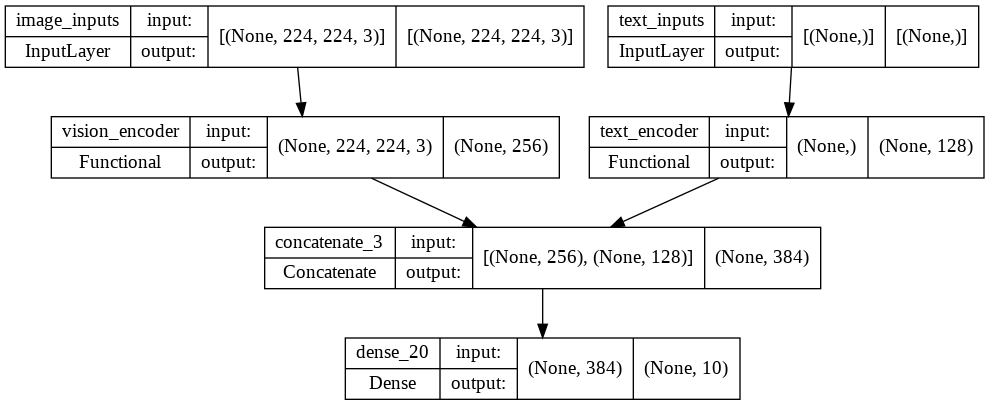

In [17]:
def create_multimodal_model(
    num_projection_layers=1,
    img_projection_dims=256,
    text_projection_dims=128,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images and text as inputs.
    image_inputs = keras.Input(shape=(224, 224, 3), name="image_inputs")
    text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_inputs")

    # Create the encoders.
    vision_encoder = create_vision_encoder(num_projection_layers, img_projection_dims, dropout_rate, vision_trainable)
    text_encoder = create_text_encoder(num_projection_layers, text_projection_dims, dropout_rate, text_trainable)

    # Fetch the embedding projections.
    vision_projections = vision_encoder(image_inputs)
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(10, activation="softmax")(concatenated)
    return keras.Model([image_inputs, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [ ]:
multimodal_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy"
)

# Text Data    # For Testing only


In [ ]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text

In [ ]:
text_data_root = pathlib.Path('/content/drive/MyDrive/tobaco_OCR/')

print(text_data_root)
for item in text_data_root.iterdir():
  print(item)

/content/drive/MyDrive/tobaco_OCR
/content/drive/MyDrive/tobaco_OCR/Resume
/content/drive/MyDrive/tobaco_OCR/Memo
/content/drive/MyDrive/tobaco_OCR/Letter
/content/drive/MyDrive/tobaco_OCR/Report
/content/drive/MyDrive/tobaco_OCR/Email
/content/drive/MyDrive/tobaco_OCR/ADVE
/content/drive/MyDrive/tobaco_OCR/News
/content/drive/MyDrive/tobaco_OCR/Note
/content/drive/MyDrive/tobaco_OCR/Form
/content/drive/MyDrive/tobaco_OCR/Scientific


In [ ]:
def get_file_paths_and_labels(data_root):
     text_paths = [str(path) for path in data_root.glob('*/*.txt')]
     labels = [p.split("/")[-2] for p in text_paths]
     return text_paths, labels

text_paths, labels = get_file_paths_and_labels(text_data_root)
print(len(text_paths))
print(len(labels))

3482
3482


In [ ]:
text_df = pd.DataFrame(list(zip(text_paths, labels)),
               columns =['text_path', 'data_label'])
text_df.head()

,text_path,data_label
0,/content/drive/MyDrive/tobaco_OCR/Resume/50521...,Resume
1,/content/drive/MyDrive/tobaco_OCR/Resume/50630...,Resume
2,/content/drive/MyDrive/tobaco_OCR/Resume/40028...,Resume
3,/content/drive/MyDrive/tobaco_OCR/Resume/10150...,Resume
4,/content/drive/MyDrive/tobaco_OCR/Resume/50538...,Resume


In [ ]:
def get_text_from_path(path):
    with open(path) as f:
        lines = f.readlines()
        lines  = ' '.join(lines)
        f.close()
    return lines

out_text = get_text_from_path('/content/drive/MyDrive/tobaco_OCR/ADVE/0000435350.txt') 
print(out_text)


 TE che fitm
 m66400 7127
 KOOLS are the only cigarettes that taste
 good when you have &® cold. They taste even
 better when you don't.
 Job No, K-2978
 ‘Mevapapars—300 iner—Mareh & April, 1956
 (5 9-4 in 4 108 ines) Pinel Proof (7) March 15, 1956



In [40]:
# preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2"
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_model = hub.KerasLayer(encoder_url)

In [ ]:
texts = []
c = 0
for this_path in text_paths:
    texts.append(get_text_from_path(this_path))
    print(c)
    c += 1

In [ ]:
text_preprocessed = bert_preprocess_model(texts)
bert_results = bert_model(text_preprocessed)

In [ ]:
out = bert_results['pooled_output']

TensorShape([3482, 128])

In [ ]:
vec_df = pd.DataFrame(out)

## this vec_df contain the senetence embedding for the texts (No labels added yet)

# Image data


In [47]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pathlib
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
a = [[1,2],[3,4]]
b = []